In [200]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [201]:
## NEURON PARAMTERS
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 1.
v = 0
delta_u = 1.
mu_M = 1e-3
mu_Q = 1e-4
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [202]:
## NETWORK PARAMTERS
num_visible = 9
num_hidden = 9
num_neurons = num_visible + num_hidden
num_timebins = 1000

In [203]:
## INITIALIZE WEIGHTS
weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M, 0)

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_Q, 0)

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

In [204]:
# INITIALIZE NETWORK RUN
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

In [205]:
## GENERATE RANDOM SPIKES
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta
    
    # potential is weighted sum
    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential
    
    # firiing intensity
    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

    # generate spikes randomly as in paper
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

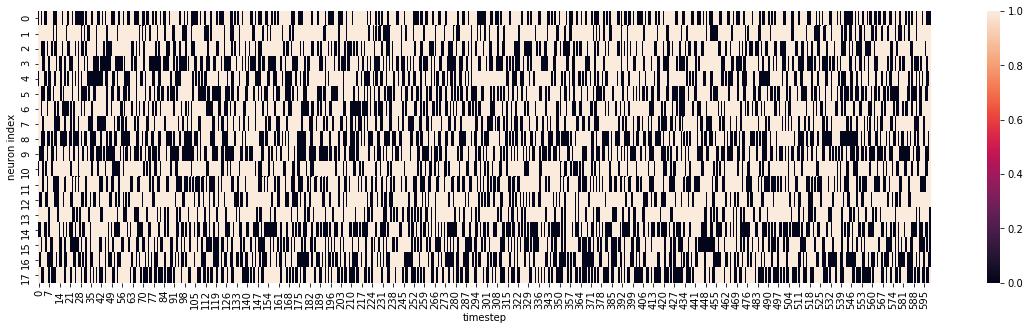

In [206]:
## HEATMAP OF GENERATED SPIKES
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(spikes[:, :600])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [207]:
# INITIALIZE NETWORK RUN
phi_Q = np.zeros(shape = (num_neurons, num_timebins))
rho_Q = np.zeros(shape = (num_neurons, num_timebins))
eta_Q = np.zeros(shape = (num_neurons, num_timebins))
u_Q = np.zeros(shape = (num_neurons, num_timebins))
spikes_Q = np.zeros(shape = (num_neurons, num_timebins))
spike_probs_Q = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi_Q[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta_Q[:, 0] = np.zeros(num_neurons)
u_Q[:, 0] = np.matmul(weights_Q, phi_Q[:, 0]) - eta_Q[:, 0]
rho_Q[:, 0] = rho_0 * np.exp(u_Q[:, 0])
spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])

## GENERATE RANDOM SPIKES
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes_Q[:, tt - 1] - phi_Q[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes_Q[:, tt - 1] - eta_Q[:, tt - 1])

    phi_Q[:, tt] = phi_Q[:, tt - 1] + dphi
    eta_Q[:, tt] = eta_Q[:, tt - 1] + deta
    
    # potential is weighted sum
    total_potential = np.matmul(weights_M, phi_Q[:, tt]) - eta_0 * eta_Q[:, tt]
    u_Q[:, tt] = total_potential
    
    # firiing intensity
    rho_Q[:, tt] = rho_0 * np.exp((u_Q[:, tt] - v) / delta_u)

    # generate spikes randomly as in paper
    spike_probs_Q[:, tt] = 1-np.exp(-dt*rho_Q[:, tt])
    spikes_Q[:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[:, tt])

In [208]:
## GENERATE STAIRCASE PATTERN

def get_staircase(num_timebins):
    # INITIALIZE NETWORK RUN
    phi = np.zeros(shape = (num_neurons, num_timebins))
    rho = np.zeros(shape = (num_neurons, num_timebins))
    eta = np.zeros(shape = (num_neurons, num_timebins))
    u = np.zeros(shape = (num_neurons, num_timebins))
    spikes = np.zeros(shape = (num_neurons, num_timebins))
    spike_probs = np.zeros(shape = (num_neurons, num_timebins))

    # phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
    phi[:, 0] = np.zeros(num_neurons)
    # eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
    eta[:, 0] = np.zeros(num_neurons)
    u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
    rho[:, 0] = rho_0 * np.exp(u[:, 0])
    spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
    spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])


    neuron_block_size = np.floor(num_visible / 3)
    curr_neuron_block = np.random.choice([0, 1, 2])
    interval_idx = 0
    timebin_counter = 0

    # intervals for length of "stairs"
    gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=2).astype(int)
    gaussian_intervals[gaussian_intervals <= 0] = 1

    spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    # simulate network
    for tt in range(1, num_timebins):

        # changes in potential
        dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
        deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

        phi[:, tt] = phi[:, tt - 1] + dphi
        eta[:, tt] = eta[:, tt - 1] + deta

        total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
        u[:, tt] = total_potential

        nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    #     u[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 5.0
    #     u[nonblock_idx, tt] -= 1.0

        # firing intensity
        rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

        # increase intensity of current stair neurons
    #     rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 4.0

    #     # decrease intensity of non-stair neurons
    #     nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    #     rho[nonblock_idx, tt] = 0.05

        # generate spikes randomly as in paper
        spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])

        spike_probs[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = 0.99
        spike_probs[nonblock_idx, tt] = 0.001

        spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

        # which neurons are the new stairs?
        timebin_counter += 1
        if timebin_counter == gaussian_intervals[interval_idx]:
            interval_idx += 1
            timebin_counter = 0
            if curr_neuron_block < 2:
                curr_neuron_block += 1
            else:
                curr_neuron_block = 0
                
    return spikes, phi, eta, rho, u, spike_probs

In [209]:
# ## GENERATE STAIRCASE PATTERN

# neuron_block_size = np.floor(num_visible / 3)
# curr_neuron_block = 0
# interval_idx = 0
# timebin_counter = 0

# # intervals for length of "stairs"
# gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=2).astype(int)
# gaussian_intervals[gaussian_intervals <= 0] = 1

# spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

# # simulate network
# for tt in range(1, num_timebins):
    
#     # changes in potential
#     dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
#     deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

#     phi[:, tt] = phi[:, tt - 1] + dphi
#     eta[:, tt] = eta[:, tt - 1] + deta

#     total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
#     u[:, tt] = total_potential
    
#     nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
# #     u[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 5.0
# #     u[nonblock_idx, tt] -= 1.0

#     # firing intensity
#     rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
#     # increase intensity of current stair neurons
# #     rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 4.0
    
# #     # decrease intensity of non-stair neurons
# #     nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
# #     rho[nonblock_idx, tt] = 0.05

#     # generate spikes randomly as in paper
#     spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    
#     spike_probs[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = 0.99
#     spike_probs[nonblock_idx, tt] = 0.001

#     spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
#     # which neurons are the new stairs?
#     timebin_counter += 1
#     if timebin_counter == gaussian_intervals[interval_idx]:
#         interval_idx += 1
#         timebin_counter = 0
#         if curr_neuron_block < 2:
#             curr_neuron_block += 1
#         else:
#             curr_neuron_block = 0

In [210]:
# spikes = get_staircase(num_timebins)

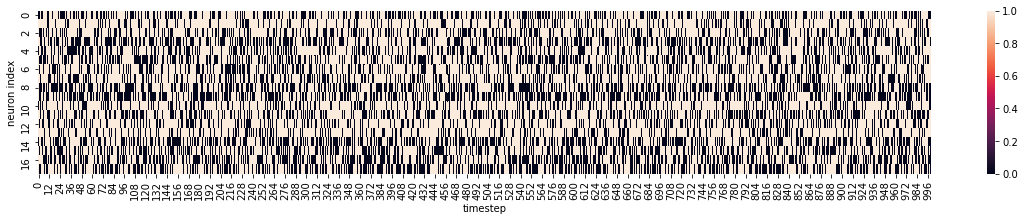

In [211]:
## HEATMAP OF GENERATED SPIKES
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :1000])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [212]:
## FUNCTIONS FOR M AND Q LIKELIHOODS AND THEIR GRADIENTS

import autograd.numpy as np

## Likelihood of M network
def LL_M(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta
    
    curr_rho = 1 / (1 + np.exp(-total_potential))

#     curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
#     curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network 
                                                               # (NOTE: this doesn't work in autograd, so I switched 
                                                               # to computing the M gradient by hand)

#     LL = np.sum(np.multiply(np.log(curr_rho), spikes) - curr_rho) * dt
#     LL_visible = np.sum(np.multiply(np.log(curr_rho[:num_visible, :]), spikes[:num_visible, :]) - curr_rho[:num_visible, :]) * dt
#     LL_hidden = np.sum(np.multiply(np.log(rho_Q[num_visible:, :]), spikes[num_visible:, :]) - rho_Q[num_visible:, :]) * dt

#     LL_visible = np.sum(np.multiply(spikes[:num_visible, :], np.log(curr_rho[:num_visible, :])) * dt + np.multiply((1 - spikes[:num_visible, :]), np.log(1 - curr_rho[:num_visible, :] * dt)))
#     LL_hidden = np.sum(np.multiply(spikes[num_visible:, :], np.log(rho_Q[num_visible:, :])) * dt + np.multiply((1 - spikes[num_visible:, :]), np.log(1 - rho_Q[num_visible:, :] * dt)))
#     return -(LL_visible + LL_hidden)

    LL = np.sum(np.multiply(spikes, np.log(curr_rho)) * dt + np.multiply((1 - spikes), np.log(1 - curr_rho)) * dt)
    return -LL

# Data log-likelihood
def data_log_likelihood(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes) - curr_rho
    LL = np.sum(individual_likelihoods[:num_visible, :]) * dt
    return LL

# M gradient by hand
def LL_M_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy() 
    
    spike_intensity_diff = spikes - curr_rho
    M_grad = -np.matmul(spike_intensity_diff, phi.T) * dt
    return M_grad


## Likelihood of Q network (only sums over hidden neurons)
def LL_Q(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

#     curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    curr_rho = 1.0 / (1 + np.exp(-total_potential))
    
#     individual_likelihoods = np.multiply(np.log(curr_rho), spikes) - curr_rho
#     individual_likelihoods = np.multiply(np.log(rho_Q), spikes_Q) - rho_Q
#     LL = np.sum(individual_likelihoods[num_visible:, :]) * dt # only sum over hidden

    # bernoulli
    individual_likelihoods = np.multiply(spikes, np.log(curr_rho)) * dt + np.multiply((1 - spikes), np.log(1 - curr_rho * dt))
    LL = np.sum(individual_likelihoods[num_visible:, :]) * dt
    return -LL

# Q gradient by hand
def LL_Q_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    spike_intensity_diff = spikes_Q - curr_rho
    Q_grad = -np.matmul(spike_intensity_diff, phi_Q.T) * dt
    return Q_grad


def free_energy_expectationQ(curr_weights):
    
    # get LL of M network
    total_potential = np.matmul(learned_weights_M, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
#     curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes) - curr_rho
    LL_M = np.sum(individual_likelihoods[:num_visible, :]) * dt
    individual_likelihoodsQ = np.multiply(np.log(rho_Q), spikes_Q) - rho_Q
    LL_M += np.sum(individual_likelihoodsQ[num_visible:, :]) * dt
    
    # get LL of Q network
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])
    
    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes_Q) - curr_rho
    LL_Q = np.sum(individual_likelihoods[num_visible:, :]) * dt
    
    return LL_Q - LL_M

def free_energy_expectationM(curr_weights):
    
    # get LL of M network
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])
    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
#     curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes) - curr_rho
    LL_M = np.sum(individual_likelihoods[:num_visible, :]) * dt
    individual_likelihoodsQ = np.multiply(np.log(rho_Q), spikes_Q) - rho_Q
    LL_M += np.sum(individual_likelihoodsQ[num_visible:, :]) * dt
    
    
    # get LL of Q network
    total_potential = np.matmul(learned_weights_Q, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes_Q) - curr_rho
    LL_Q = np.sum(individual_likelihoods[num_visible:, :]) * dt
    
    return LL_Q - LL_M


In [213]:
# GRADIENTS COURTESY OF AUTOGRAD
grad_LL_M = grad(LL_M)
grad_LL_Q = grad(LL_Q)
grad_LL_Q2 = grad(free_energy_expectationQ)
grad_LL_M2 = grad(free_energy_expectationM)

In [214]:
# INITIALIZE WEIGHTS FOR LEARNING
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

In [215]:
# VALUES TO STORE OVER TRAINING
free_energy_trace = []
mean_subtract_free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []

In [216]:
# LEARNING PARAMETERS
num_iters = 1000
variance_reduction_window = 1000 # window of past free energies to average and subtract (reduces gradient variance)

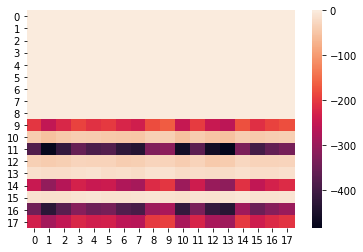

In [217]:
sns.heatmap(grad_LL_Q2(learned_weights_Q))

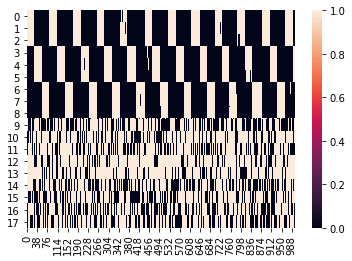

In [218]:
spikes, phi, eta, rho, u, spike_probs = get_staircase(num_timebins)
sns.heatmap(spikes)

iter: 0, M: 2498.799515, Q: 1249.03741235, Data LL: -1729.1273586


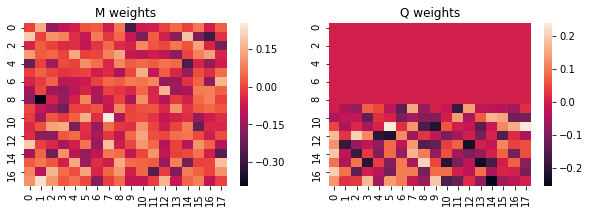

KeyboardInterrupt: 

In [219]:
## TRAINING
num_timebins = 200

for iter_num in range(10000):
    
    spikes, phi, eta, rho, u, spike_probs = get_staircase(num_timebins)

    ## GET READY TO SIMULATE Q NETWORK
    phi_Q = phi.copy() #np.zeros(shape = (num_neurons, num_timebins))
    rho_Q = rho.copy() #np.zeros(shape = (num_neurons, num_timebins))
    eta_Q = eta.copy() #np.zeros(shape = (num_neurons, num_timebins))
    u_Q = u #np.zeros(shape = (num_neurons, num_timebins))
    spikes_Q = np.zeros(shape = (num_neurons, num_timebins))
    spike_probs_Q = np.zeros(shape = (num_neurons, num_timebins))

    spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
    spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()


    ## SIMULATE Q FOR 1,...T TO GET HIDDEN NEURONS' SPIKES
    for tt in range(1, num_timebins):

        dphi = dt * (1 / tau) * (spikes_Q[num_visible:, tt - 1] - phi_Q[num_visible:, tt - 1])
        deta = dt * (1 / tau_adapt) * (spikes_Q[num_visible:, tt - 1] - eta_Q[num_visible:, tt - 1])

        phi_Q[num_visible:, tt] = phi_Q[num_visible:, tt - 1] + dphi
        eta_Q[num_visible:, tt] = eta_Q[num_visible:, tt - 1] + deta

        total_potential = np.matmul(learned_weights_Q[num_visible:, :], phi_Q[:, tt]) - eta_0 * eta_Q[num_visible:, tt]
        u_Q[num_visible:, tt] = total_potential

        rho_Q[num_visible:, tt] = rho_0 * np.exp((u_Q[num_visible:, tt] - v) / delta_u)

        spike_probs_Q[num_visible:, tt] = 1-np.exp(-dt*rho_Q[num_visible:, tt])
        
        spike_probs_Q[num_visible:, tt] = 1 / (1 + np.exp(-u_Q[num_visible:, tt]))
        spikes_Q[num_visible:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[num_visible:, tt])
        
    # Spikes of visibles are always determined by the data
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()

    # Set hidden neuron activity to be those just simulated from Q network
    spikes[num_visible:, :] = spikes_Q[num_visible:, :].copy()
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy()
    rho[num_visible:, :] = rho_Q[num_visible:, :].copy()
    eta[num_visible:, :] = eta_Q[num_visible:, :].copy()
    u[num_visible:, :] = u_Q[num_visible:, :].copy()
    spike_probs[num_visible:, :] = spike_probs_Q[num_visible:, :].copy()

    # DATA LOG LIKELIHOOD
    curr_data_LL = data_log_likelihood(learned_weights_M)
    
    ## M likelihood
    curr_LL_M = LL_M(learned_weights_M)
    LL_M_trace.append(curr_LL_M)
    
    # M gradient
    M_weights_gradients = grad_LL_M(learned_weights_M)
#     M_weights_gradients = LL_M_gradient_by_hand(learned_weights_M)
#     M_weights_gradients = grad_LL_M2(learned_weights_M)
    
    # update M weights
    learned_weights_M -= mu_M * M_weights_gradients
    np.fill_diagonal(learned_weights_M[:num_visible, :num_visible], 0)

    # Q likelihood
    curr_LL_Q = LL_Q(learned_weights_Q)
    LL_Q_trace.append(curr_LL_Q)
    
    # Q gradient
    Q_weights_gradients = grad_LL_Q(learned_weights_Q)
#     Q_weights_gradients = LL_Q_gradient_by_hand(learned_weights_Q)
#     Q_weights_gradients = grad_LL_Q2(learned_weights_Q)
    
    # Calculate point estimate of free energy
    free_energy = curr_LL_Q - curr_LL_M
    free_energy_trace.append(free_energy)

    # Variance reduction technique from paper (mean-subtract free energy)
    if iter_num == 0:
        curr_free_energy = 1
    else:
        curr_window_start_idx = max(-variance_reduction_window, -len(free_energy_trace))
        curr_free_energy = free_energy - np.mean(free_energy_trace[curr_window_start_idx:])
        mean_subtract_free_energy_trace.append(curr_free_energy)

    # update Q weights
    learned_weights_Q -= mu_Q * Q_weights_gradients * curr_free_energy

    # reset connections to visible to 0
    learned_weights_Q[:num_visible, :] = 0
    
    # reset self-connections to 0
#     np.fill_diagonal(learned_weights_Q, 0)
    
    # print progress
    if iter_num % 100 == 0:
        print 'iter: {}, M: {}, Q: {}, Data LL: {}'.format(iter_num, curr_LL_M, curr_LL_Q, curr_data_LL)
        
        ## HEATMAP LEARNED WEIGHTS
        f = plt.figure(figsize=(10, 3))
        f.add_subplot(121)
        plt.title("M weights")
        sns.heatmap(learned_weights_M)
        f.add_subplot(122)
        sns.heatmap(learned_weights_Q)
        plt.title("Q weights")
        plt.show()
#         print np.sum((learned_weights_Q - weights_Q)**2)



In [ ]:
sns.heatmap(learned_weights_M[:, num_visible:][:, np.argsort(-learned_weights_M[0, num_visible:])])

In [ ]:
plt.plot(mean_subtract_free_energy_trace)

In [ ]:
## PLOT LOSS OVER TIME
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M -LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q -LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
## HEATMAP Q SPIKES AND FIRING INTENSITIES
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_Q[:, :600])
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(rho_Q[:, :600])
plt.title("Firing intensities")
plt.show()

In [ ]:
# np.fill_diagonal(learned_weights_M, 0)

## HEATMAP LEARNED WEIGHTS
f = plt.figure(figsize=(10, 3))
f.add_subplot(121)
plt.title("M weights")
sns.heatmap(learned_weights_M)
f.add_subplot(122)
sns.heatmap(learned_weights_Q)
plt.title("Q weights")
plt.show()

In [ ]:
sns.heatmap(learned_weights_M)
plt.savefig('./plots/m_weights.png')

In [ ]:
## SIMULATE LEARNED M NETWORK
curr_neuron_block = 0

spikes, phi, eta, rho, u, spike_probs = get_staircase(num_timebins)

num_simulated_timebins = 1000
phi_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
rho_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
eta_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
u_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
spikes_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
spike_probs_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))


phi_sim[:, :num_timebins] = phi.copy()
eta_sim[:, :num_timebins] = eta.copy()
rho_sim[:, :num_timebins] = rho.copy()
spikes_sim[:, :num_timebins] = spikes.copy()
u_sim[:, :num_timebins] = u.copy()
# phi[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

# for tt in range(np.sum(gaussian_intervals[:3]), 1000): #num_timebins):
for tt in range(1, 1000): #num_timebins):
        
    dphi = dt * (1 / tau) * (spikes_sim[:, tt - 1] - phi_sim[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes_sim[:, tt - 1] - eta_sim[:, tt - 1])

    phi_sim[:, tt] = phi_sim[:, tt - 1] + dphi
    eta_sim[:, tt] = eta_sim[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_M, phi_sim[:, tt]) - eta_0 * eta_sim[:, tt]
    u_sim[:, tt] = total_potential 

    rho_sim[:, tt] = rho_0 * np.exp((u_sim[:, tt] - v) / delta_u)

#     spike_probs_sim[:, tt] = 1-np.exp(-dt*rho_sim[:, tt])
#     spike_probs[:, tt] = 1 - np.exp(-rho_0 * np.exp(np.matmul(learned_weights_M, phi[:, tt]) - eta_0 * eta[:, tt]))

    spike_probs_sim[:, tt] = 1 / (1 + np.exp(-u_sim[:, tt]))

    if tt <= 90:
        spikes_sim[num_visible:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[num_visible:, tt])
    else:
        spikes_sim[:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[:, tt])

In [ ]:
## HEATMAP SIMULATED M NETWORK
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim[:, :600]) #, xticklabels=False, yticklabels=False)
plt.ylabel("Neuron")
plt.title("Spikes")
# plt.tight_layout()
# plt.subplots_adjust(top=0.88) #, bottom=1.5)
plt.savefig("./plots/m_network_simulated_spikes.png", bbox_inches='tight')
plt.show()

# fig, ax = plt.subplots(figsize=(20, 3))
# sns.heatmap(rho[num_visible:])
# plt.show()

row_sums = np.max(rho_sim, axis=1) #rho.sum(axis=1)
rho_row_normalized = rho / row_sums[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(phi_sim[:, :600]) #, xticklabels=False, yticklabels=False)
plt.title("Firing intensity")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.show()

In [ ]:
## staircase pattern
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

gaussian_intervals = np.random.normal(size = 10000, loc=30, scale=2).astype(int)
gaussian_intervals[gaussian_intervals <= 0] = 1

num_simulated_timebins = 1000
phi_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
rho_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
eta_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
u_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
spikes_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))
spike_probs_sim = np.zeros(shape = (num_neurons, num_simulated_timebins))

    
for tt in range(1, 1000):
                
    dphi = dt * (1 / tau) * (spikes_sim[:, tt - 1] - phi_sim[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes_sim[:, tt - 1] - eta_sim[:, tt - 1])

    phi_sim[:, tt] = phi_sim[:, tt - 1] + dphi
    eta_sim[:, tt] = eta_sim[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_Q, phi_sim[:, tt]) - eta_0 * eta_sim[:, tt]
    u_sim[:, tt] = total_potential

    rho_sim[:, tt] = rho_0 * np.exp((u_sim[:, tt] - v) / delta_u)
    
#     rho_sim[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    
#     rho_sim[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
#     rho_sim[nonblock_idx, tt] = 0.05


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
#     spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    
    spike_probs_sim[:, tt] = 1 / (1 + np.exp(-u_sim[:, tt]))
    
    spike_probs_sim[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] = 0.7
    spike_probs_sim[nonblock_idx, tt] = 0.001
    spikes_sim[:, tt] = np.random.binomial(n = 1, p = spike_probs_sim[:, tt])
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_sim[:, :600])
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spike_probs_sim[:, :600])
plt.title("Firing intensities")
plt.show()

In [ ]:
sns.heatmap(phi)